In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import load_model

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from collections import defaultdict
import cv2

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_dir = 'Dataset'

classes = os.listdir(base_dir)
print("Classes Found:", classes)

Classes Found: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [3]:
for cls in classes:
    cls_dir = os.path.join(base_dir,cls)
    num_images = len(os.listdir(cls_dir))
    print(f"Number of images in class {cls}: {num_images}")



Number of images in class Blight: 1146
Number of images in class Common_Rust: 1306
Number of images in class Gray_Leaf_Spot: 574
Number of images in class Healthy: 1162


In [4]:
image_shape = {}

for cls in classes:
    cls_dir = os.path.join(base_dir,cls)
    images = os.listdir(cls_dir)[:5]
    shapes = []
    for img_name in images:
        img_path = os.path.join(cls_dir,img_name)
        img = cv2.imread(img_path)
        if img is not None:
            shapes.append(img.shape[:2])
            image_shape[cls] = shapes

for cls, dims in image_shape.items():
    print(f"Sample image dimensions for class '{cls}': {dims}")

Sample image dimensions for class 'Blight': [(585, 1000), (371, 788), (482, 641), (200, 300), (256, 256)]
Sample image dimensions for class 'Common_Rust': [(500, 185), (480, 640), (256, 256), (256, 256), (256, 256)]
Sample image dimensions for class 'Gray_Leaf_Spot': [(395, 525), (1591, 743), (256, 256), (256, 256), (256, 256)]
Sample image dimensions for class 'Healthy': [(256, 256), (256, 256), (256, 256), (256, 256), (256, 256)]


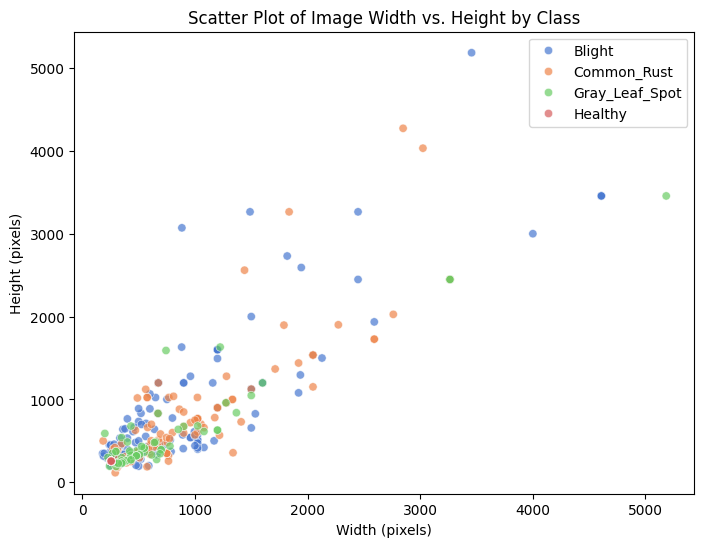

In [5]:
def img_stats(base_dir, classes):
    img_size = defaultdict(list)
    for cls in classes:
        cls_dir = os.path.join(base_dir,cls)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                height, width = img.shape[:2]
                img_size['Class'].append(cls)
                img_size['Height'].append(height)
                img_size['Width'].append(width)
    return pd.DataFrame(img_size)

# Function to plot a scatter plot of Height vs. Width
def plot_scatter(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='Width', y='Height', hue='Class', alpha=0.7, palette='muted')
    plt.title('Scatter Plot of Image Width vs. Height by Class')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.legend(loc='upper right')
    plt.show()

df_img_sizes = img_stats(base_dir, classes)
plot_scatter(df_img_sizes)

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 40

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('Dataset',
                                                              seed = 123,
                                                              shuffle = True,
                                                              image_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                              batch_size = BATCH_SIZE
                                                              )

Found 4188 files belonging to 4 classes.


In [10]:
len(dataset) # gets the total number of batches in the dataset

131

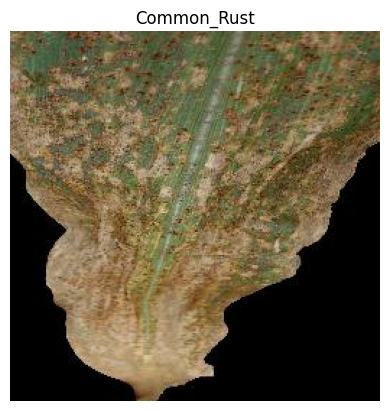

In [ ]:
class_names = dataset.class_names        # Displaying a single image from a batch

for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    plt.axis("off")
    plt.show()

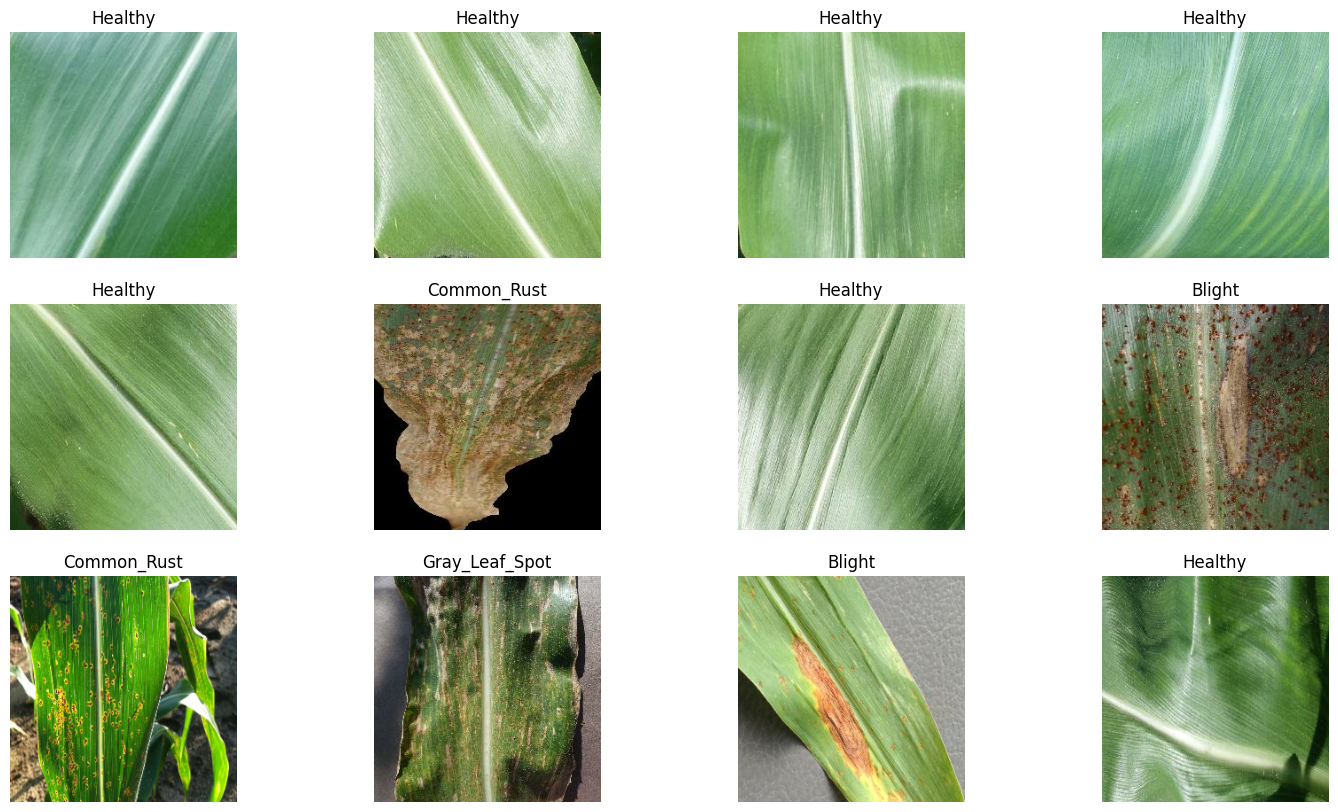

In [14]:
plt.figure(figsize=(18,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.show()


In [15]:
def dataset_partitions(ds, train_split = 0.8, test_split = 0.1, val_split = 0.1,shuffle = True, shuffle_size = 10000):
    assert (train_split+test_split+val_split) == 1

    ds_size = ds.cardinality().numpy()
    print(f"Total dataset size: {ds_size}")

    if shuffle:
        shuffle_size = max(shuffle_size, ds_size)
        ds = ds.shuffle(shuffle_size,seed=123)

    # Calculate partition sizes
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size-train_size-val_size

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size+val_size)

    return train_ds, test_ds, val_ds

# Split the dataset
train_ds, val_ds, test_ds = dataset_partitions(dataset)

# Output the number of batches
print(f"Training batches: {len(train_ds)}")   
print(f"Validation batches: {len(val_ds)}")  
print(f"Testing batches: {len(test_ds)}")    

Total dataset size: 131
Training batches: 104
Validation batches: 14
Testing batches: 13


In [16]:
resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

train_ds = train_ds.map(lambda x, y: (resize(x), y))
val_ds = val_ds.map(lambda x, y: (resize(x), y))
test_ds = test_ds.map(lambda x, y: (resize(x), y))

In [18]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

train_ds = train_ds.map(lambda x,y: (data_augmentation(x),y))

In [35]:
n_classes = 4

#model
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),

    #First con layer
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    #Second con layer
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    #Third Con layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    #Fourth Con layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    #global average pooling
    layers.GlobalAveragePooling2D(),
    # layers.Flatten(),

    #Dense layer
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [36]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,756 (979.52 KB)

 Trainable params: 250,052 (976.77 KB)

 Non-trainable params: 704 (2.75 KB)

In [38]:
model_layers = [layer.name for layer in model.layers]
for index, layer_name in enumerate(model_layers):
    print(f"Layer {index} : {layer_name}")

Layer 0 : conv2d_36
Layer 1 : batch_normalization_36
Layer 2 : max_pooling2d_36
Layer 3 : conv2d_37
Layer 4 : batch_normalization_37
Layer 5 : max_pooling2d_37
Layer 6 : conv2d_38
Layer 7 : batch_normalization_38
Layer 8 : max_pooling2d_38
Layer 9 : conv2d_39
Layer 10 : batch_normalization_39
Layer 11 : max_pooling2d_39
Layer 12 : global_average_pooling2d_4
Layer 13 : dropout_8
Layer 14 : dense_16
Layer 15 : dense_17
